In [1]:
import re
import numpy as np
import pandas as pd
import networkx as nx
import community
import markov_clustering as markov
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from scipy import sparse
from wordcloud import WordCloud
from modules.network import get_degree

# Get default colors
colors = [*mcolors.TABLEAU_COLORS.values()]

%matplotlib inline

In [2]:
# Define periods under analysis
years = [2017, 2018]

In [3]:
# Load dictionaries mapping indices to lemma tuples
w2i = np.load('data/edges_w2i.npy', allow_pickle=True).item()
i2w = np.load('data/edges_i2w.npy', allow_pickle=True).item()

In [4]:
# Load edges
edges = pd.read_csv('data/database/edges.csv')
edges = {y: edges[edges.year == y][['node_x', 'node_y', 'weight']] for y in years}

In [5]:
# Check edges 2017
edges[2017].head()

,node_x,node_y,weight
0,0,654,1
1,0,2466,1
2,0,2469,1
3,4,210,1
4,4,1076,1


In [6]:
# Check edges 2018
edges[2018].head()

,node_x,node_y,weight
25278,1,227,1
25279,1,323,1
25280,1,772,1
25281,1,1000,1
25282,1,1429,1


In [7]:
# Create undirected multigraph objects using edges table
networks = {}
for y in years:
    networks[y] = nx.from_pandas_edgelist(edges[y], source='node_x', target='node_y', 
                                          edge_attr=True, create_using=nx.MultiGraph)

In [8]:
# Define colors and labels for each POS tag
pos_patches = {
    'N': (colors[0], 'Noun'),  # Noun
    'V': (colors[1], 'Verb'),  # Verb
    'A': (colors[2], 'Adjective'),  # Adjective
    'R': (colors[3], 'Adverb')   # Adverb
}

# Define function for plotting cluster wordcloud
def make_word_cloud(word_cloud, scores):
    """
    Input:
    - Lemmas: list of tuples (word text, pos tag)
    - Scores: list of scores which define word importance
    Note that len(scores) = len(lemmas) must be satisfied
    Output:
    - WordCloud object
    """
    
    # Use words only to define word positions
    word_cloud = word_cloud.generate_from_frequencies(
        {word_text: score for (word_text, pos_tag), score in scores.items()}
    )
    
    # Modify layout
    for i, (word, font_size, position, orientation, color) in enumerate(word_cloud.layout_):
        # Get text and pos tag, separated
        pos_tag = scores.index[i][1]
        word_cloud.layout_[i] = (word, font_size, position, orientation, pos_patches[pos_tag][0])
    
    # Return modified wordcloud object
    return word_cloud

# MCL communities extraction

In [9]:
# MCL parameters

# Inflaction: float > 1
imin = 15       # minimum inflaction * 10
imax = 40       # maximum inflaction * 10
istep = 5       # step for inflaction exploration * 10

# Expansion: integer > 1
emin = 2        # minimum expansion 
emax = 8        # maximum expansion 
estep = 1       # step for expansion exploration

max_iter = 500  # max number of iterations for the algorithm

In [10]:
# Evaluate modularity for each set of parameters

# for k in adj_matrices.keys():
#    # convert the matrix to sparse
#    mat = sparse.csr_matrix(adj_matrices[k])
#    print('{:s}\'s network'.format(k))
#    # Grid search for best parameters
#    for inf in [i / 10 for i in range(imin, imax, istep)]:
#        for exp in [e for e in range(emin, emax, estep)]:
#            # Compute clusters
#            result = markov.run_mcl(mat, pruning_threshold = 0, iterations = max_iter, inflation = inf, expansion = exp) 
#            clusters = markov.get_clusters(mat) 
#            print("Num. clusters:",len(clusters))
#            # Compute corresponding modularity
#            Q = markov.modularity(matrix=result, clusters=clusters)
#            print("inflation:", inf, "expansion:", exp, "modularity:", Q) 

In [11]:
# Second evaluation: only on 2018 net
#
# print('\n\n2018\'s network')
# # convert the matrix to sparse
# mat = sparse.csr_matrix(X[1])
# exp = 2
# inf_range = [40, 120]
# for inf in [i/10 for i in range(inf_range[0], inf_range[1], 10)]:
#    # Compute clusters
#    result = markov.run_mcl(mat, pruning_threshold = 0, iterations = max_iter, inflation = inf, expansion = exp ) 
#    clusters = markov.get_clusters(mat) 
#    print("Num. clusters:",len(clusters))
#    # Compute corresponding modularity
#    Q = markov.modularity(matrix=result, clusters=clusters)
#    print("inflation:", inf, "expansion:", exp, "modularity:", Q) 

In [12]:
# Best parameters
params = {
    2017: {'inf': 1.5, 'exp': 4},  # mod = 0.0011712948963333333, n. clusters 48
    2018: {'inf': 3.5, 'exp': 2}   # mod = 0.023 (?) , n. clusters 112
}

# Other parameters can be tried: 
# - 2018: higher inf

In [13]:
# Compute Markov clusters

"""# Define clusters container: each cluster contains a list of nodes
mcl_clusters = {}

for y in years:
    # Retrieve adjacency matrix
    adj_matrix = nx.to_numpy_matrix(networks[y], weight='counts')
    # Convert the matrix to sparse
    adj_matrix = sparse.csr_matrix(adj_matrix)
    # Setup running Markov Clustering using best parameters
    markov.run_mcl(adj_matrix, verbose=1, pruning_threshold=0, iterations=max_iter, 
                   inflation=params[y]['inf'], expansion=params[y]['exp']) 
    # Retrieve clusters according to dimension
    clusters = sorted(markov.get_clusters(adj_matrix), key=len, reverse=True)
    # Save clusters
    mcl_clusters[y] = clusters
    
# Save clusters to disk
np.save('data/mcl_clusters.npy', mcl_clusters)"""

--------------------------------------------------
MCL Parameters
Expansion: 4
Inflation: 1.5
No pruning
Convergence check: 1 iteration
Maximum iterations: 500
Sparse matrix mode
--------------------------------------------------
Iteration 1
Checking for convergence
Iteration 2
Checking for convergence
Iteration 3
Checking for convergence
Iteration 4
Checking for convergence
Iteration 5
Checking for convergence
Iteration 6
Checking for convergence
Iteration 7
Checking for convergence
Iteration 8
Checking for convergence
Iteration 9
Checking for convergence
Converged after 9 iterations
--------------------------------------------------
--------------------------------------------------
MCL Parameters
Expansion: 2
Inflation: 3.5
No pruning
Convergence check: 1 iteration
Maximum iterations: 500
Sparse matrix mode
--------------------------------------------------
Iteration 1
Checking for convergence
Iteration 2
Checking for convergence
Iteration 3
Checking for convergence
Iteration 4
Chec

In [14]:
# Load Markov clusters from disk
mcl_clusters = np.load('data/mcl_clusters.npy', allow_pickle=True).item()

In [15]:
# Define number of clusters and nodes per clusters which must be shown for every cluster
num_clusters = 4
num_nodes = 20

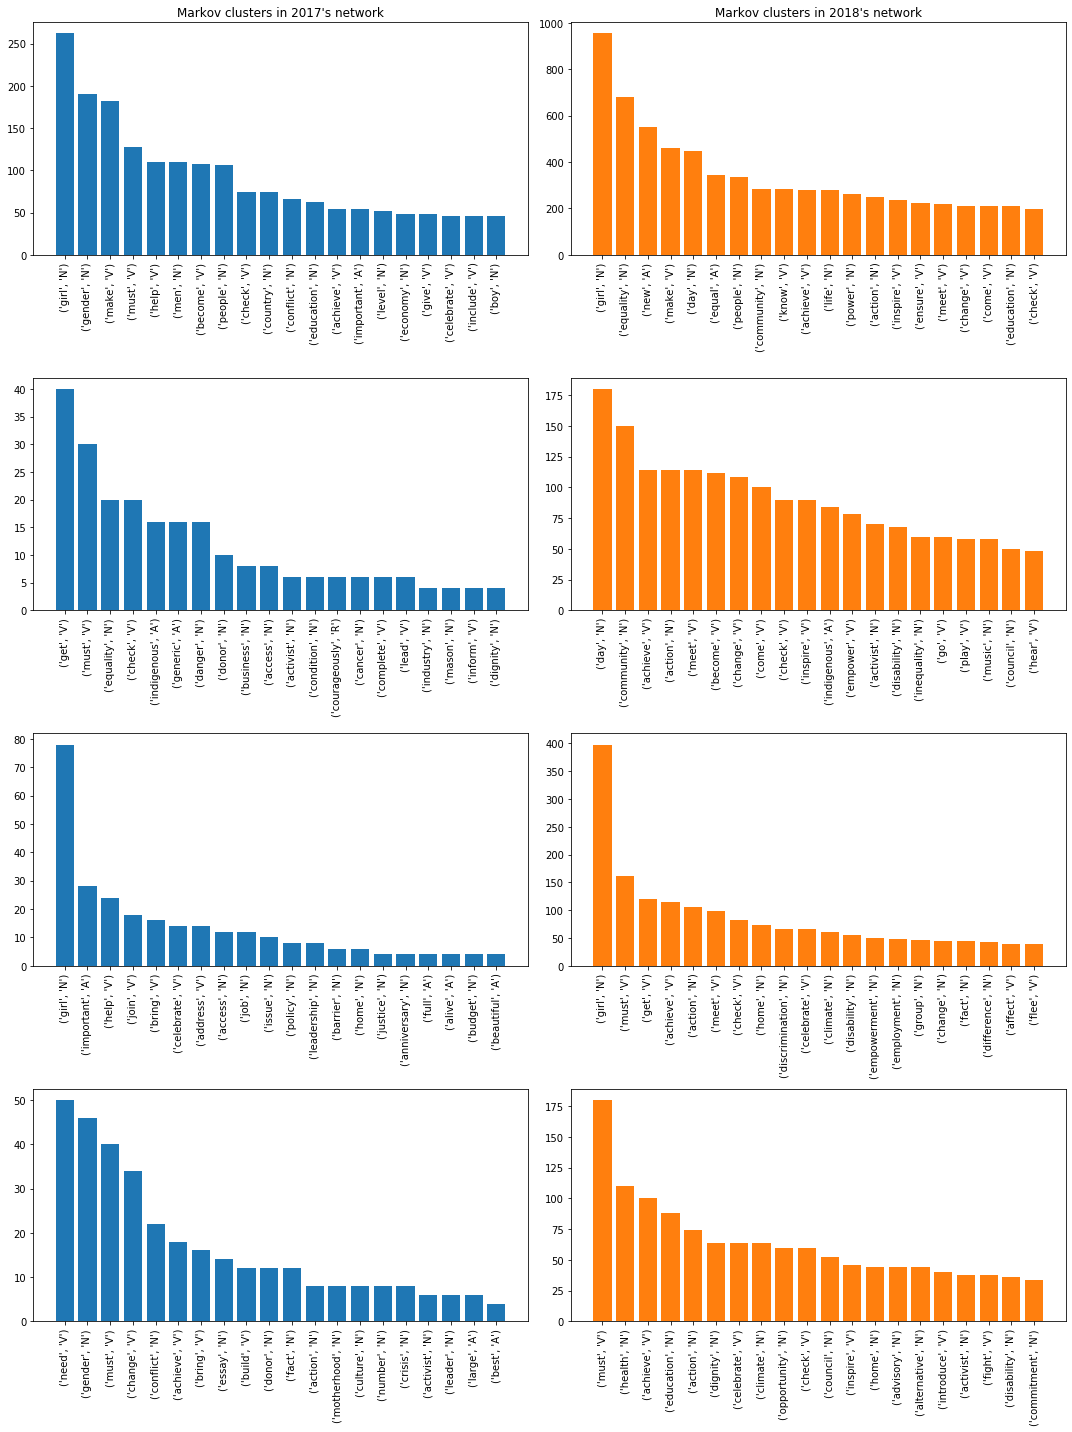

In [16]:
# Show histograms for Markov clusters

# Initialize plot
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
_ = axs[0, 0].set_title('Markov clusters in 2017\'s network')
_ = axs[0, 1].set_title('Markov clusters in 2018\'s network')
# Fill plots
for i, y in enumerate(years):
    # Retrieve clusters for current year and sort them by numerosity
    clusters = sorted(mcl_clusters[y], key=len, reverse=True)
    clusters = clusters[:num_clusters]
    # Plot every cluster
    for j, cluster in enumerate(clusters):
        # Compute degree score for each node in current cluster
        # Note: degree is a Pandas series mapping node to degree
        degree = get_degree(networks[y].subgraph(cluster)).sort_values(ascending=False)
        degree = degree[:num_nodes]
        # Plot histograms
        _ = axs[j, i].bar(degree.index.map(lambda x: str(i2w[x])).values, degree.values, color=colors[i])
        _ = axs[j, i].tick_params(axis='x', labelrotation=90)

# Show plot
_ = plt.tight_layout()
_ = plt.show()

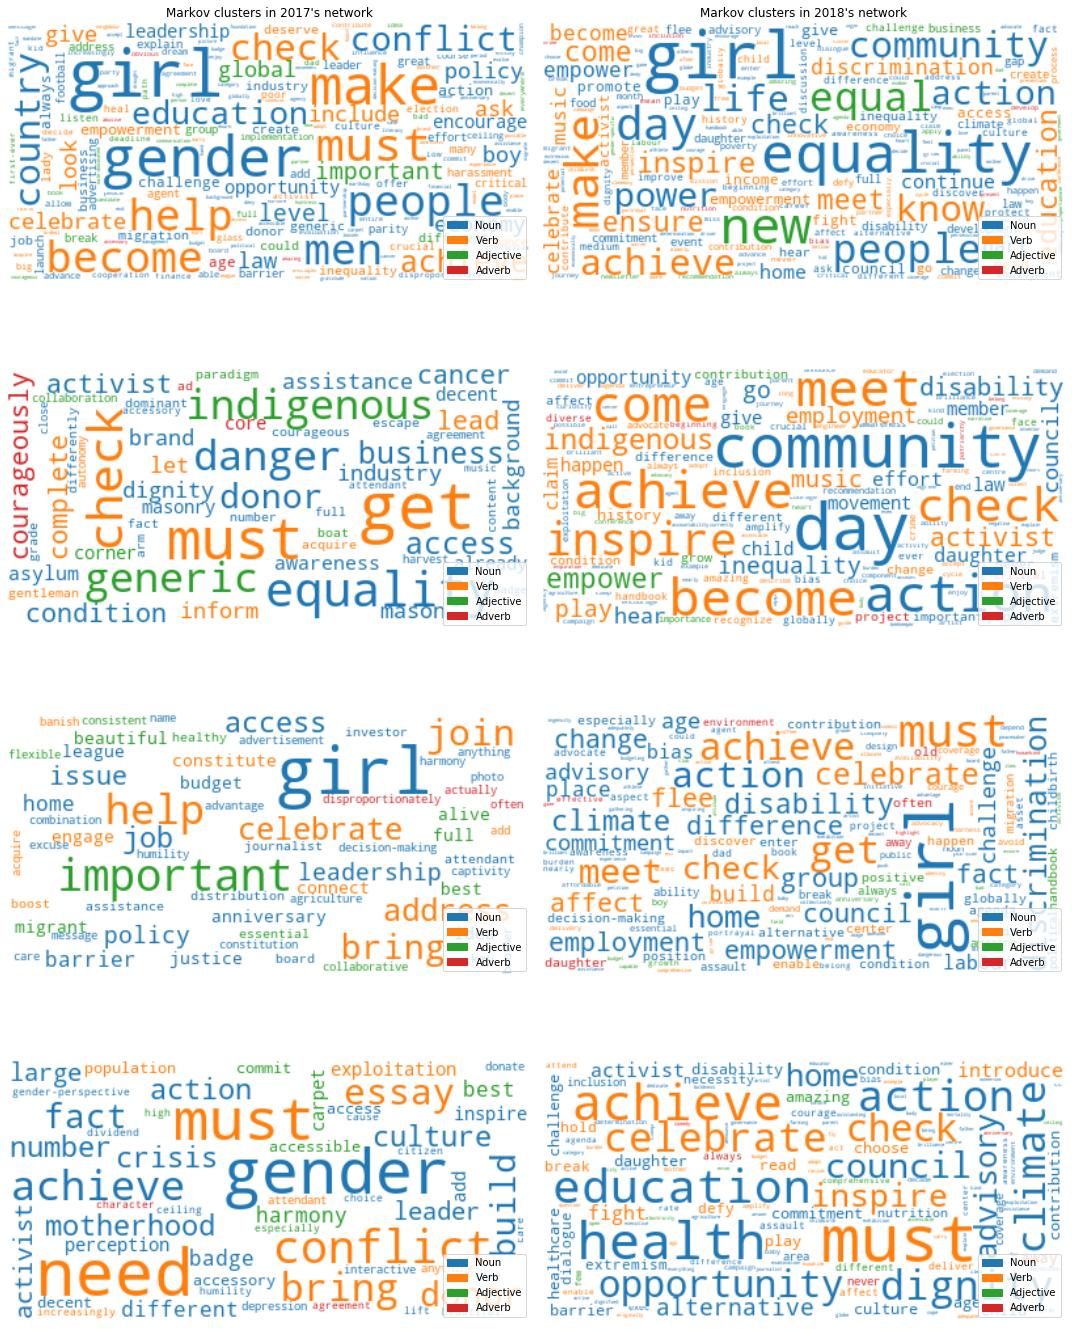

In [17]:
# Show wordclouds for Markov clusters

# Initialize plot
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
_ = axs[0, 0].set_title('Markov clusters in 2017\'s network')
_ = axs[0, 1].set_title('Markov clusters in 2018\'s network')
# Fill plots
for i, y in enumerate(years):
    # Retrieve clusters for current year and sort them by numerosity
    clusters = sorted(mcl_clusters[y], key=len, reverse=True)
    clusters = clusters[:num_clusters]
    # Plot every cluster
    for j, cluster in enumerate(clusters):
        # Compute degree score for each node in current cluster
        # Note: degree is a Pandas series mapping node to degree
        degree = get_degree(networks[y].subgraph(cluster)).sort_values(ascending=False)
        degree = degree / degree.sum()  # Scale degree
        degree.index = degree.index.map(lambda x: i2w[x])  # Map integer index to (word, pos) tuple
        # Create a WordCloud object using (word, POS tag) items
        word_cloud = make_word_cloud(WordCloud(max_font_size=50, background_color='white'), degree)
        # Plot wordclouds
        _ = axs[j, i].imshow(word_cloud, interpolation='bilinear')
        _ = axs[j, i].set_axis_off()
        _ = axs[j, i].legend(
            handles=[mpatches.Patch(color=pos_patches[k][0], label=pos_patches[k][1]) for k in pos_patches.keys()], 
            loc='lower right'
        )

# Show plot
_ = plt.tight_layout()
_ = plt.show()

# Louvain clustering 

In [18]:
"""# Compute Louvain clusters
lou_clusters = {}

# For each year, fill a list of lists of nodes
for y in years:
    # Get the cluster as node -> cluster dictionary
    node_to_cluster = community.best_partition(networks[y])
    # Turn the cluster to a cluster -> [nodes] dictionary
    clusters = {}
    for node, cluster in node_to_cluster.items():
        # Fill cluster lists
        clusters.setdefault(cluster, []).append(node)
    # Store clusters
    lou_clusters[y] = list(clusters.values())
    
# Save clusters to disk
np.save('data/lou_clusters.npy', lou_clusters)"""

In [19]:
# Load louvain clusters from disk
lou_clusters = np.load('data/lou_clusters.npy', allow_pickle=True).item()

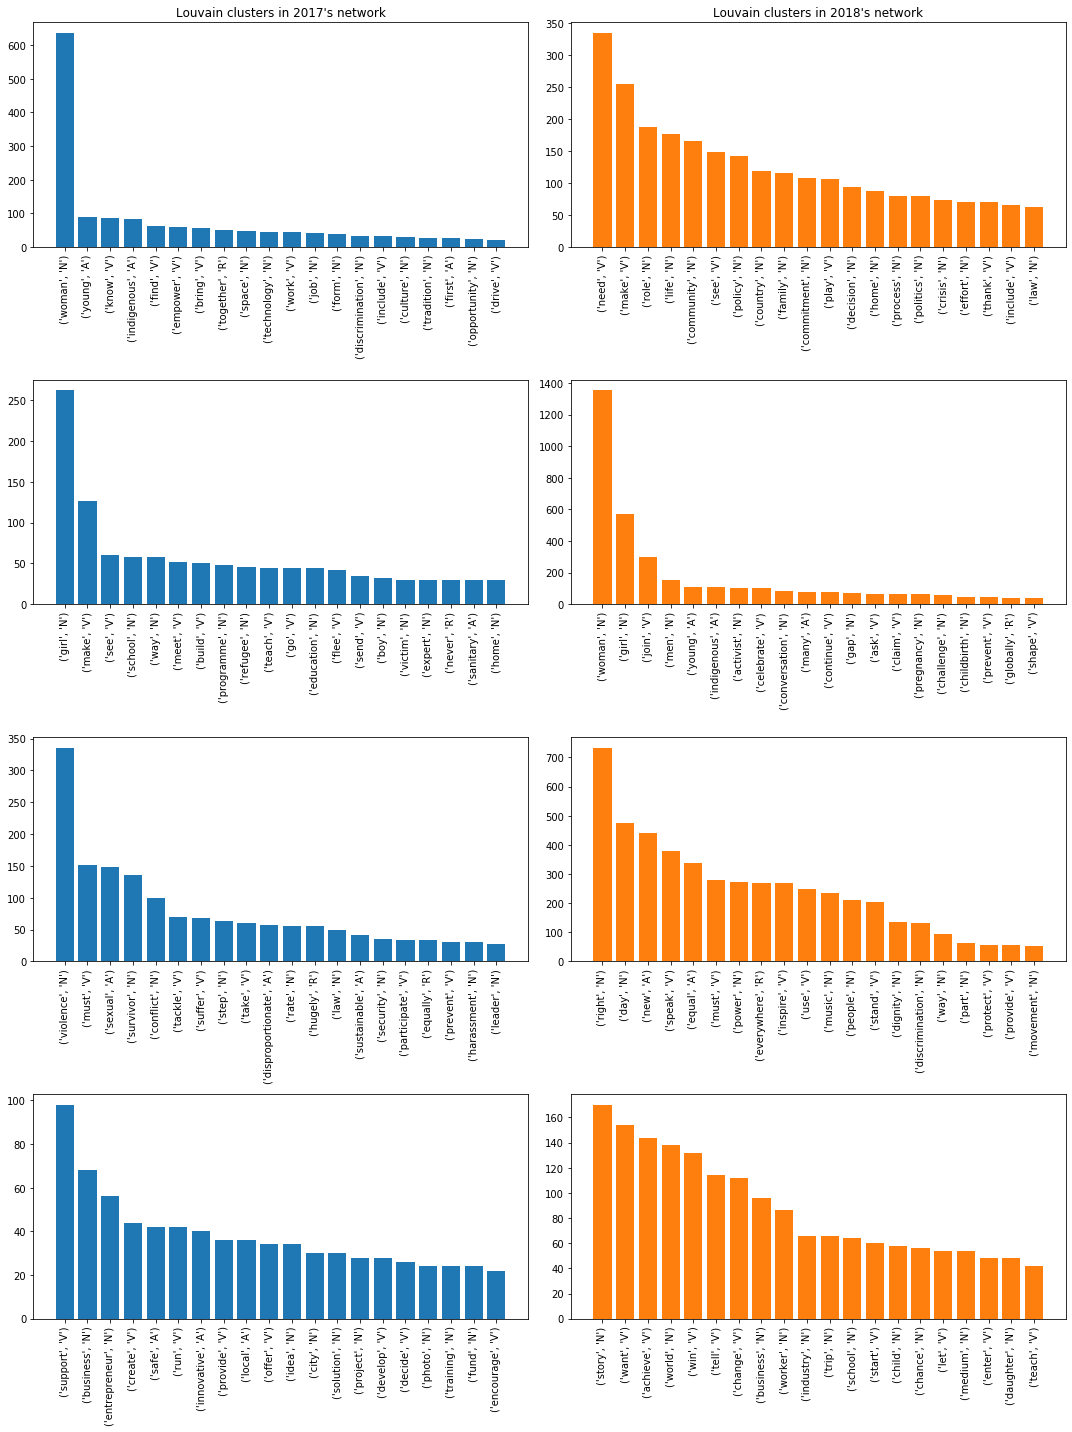

In [20]:
# Show histograms for Louvain clusters

# Initialize plot
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
_ = axs[0, 0].set_title('Louvain clusters in 2017\'s network')
_ = axs[0, 1].set_title('Louvain clusters in 2018\'s network')
# Fill plots
for i, y in enumerate(years):
    # Retrieve clusters for current year and sort them by numerosity
    clusters = sorted(lou_clusters[y], key=len, reverse=True)
    clusters = clusters[:num_clusters]
    # Plot every cluster
    for j, cluster in enumerate(clusters):
        # Compute degree score for each node in current cluster
        # Note: degree is a Pandas series mapping node to degree
        degree = get_degree(networks[y].subgraph(cluster)).sort_values(ascending=False)
        degree = degree[:num_nodes]
        # Plot histograms
        _ = axs[j, i].bar(degree.index.map(lambda x: str(i2w[x])).values, degree.values, color=colors[i])
        _ = axs[j, i].tick_params(axis='x', labelrotation=90)

# Show plot
_ = plt.tight_layout()
_ = plt.show()

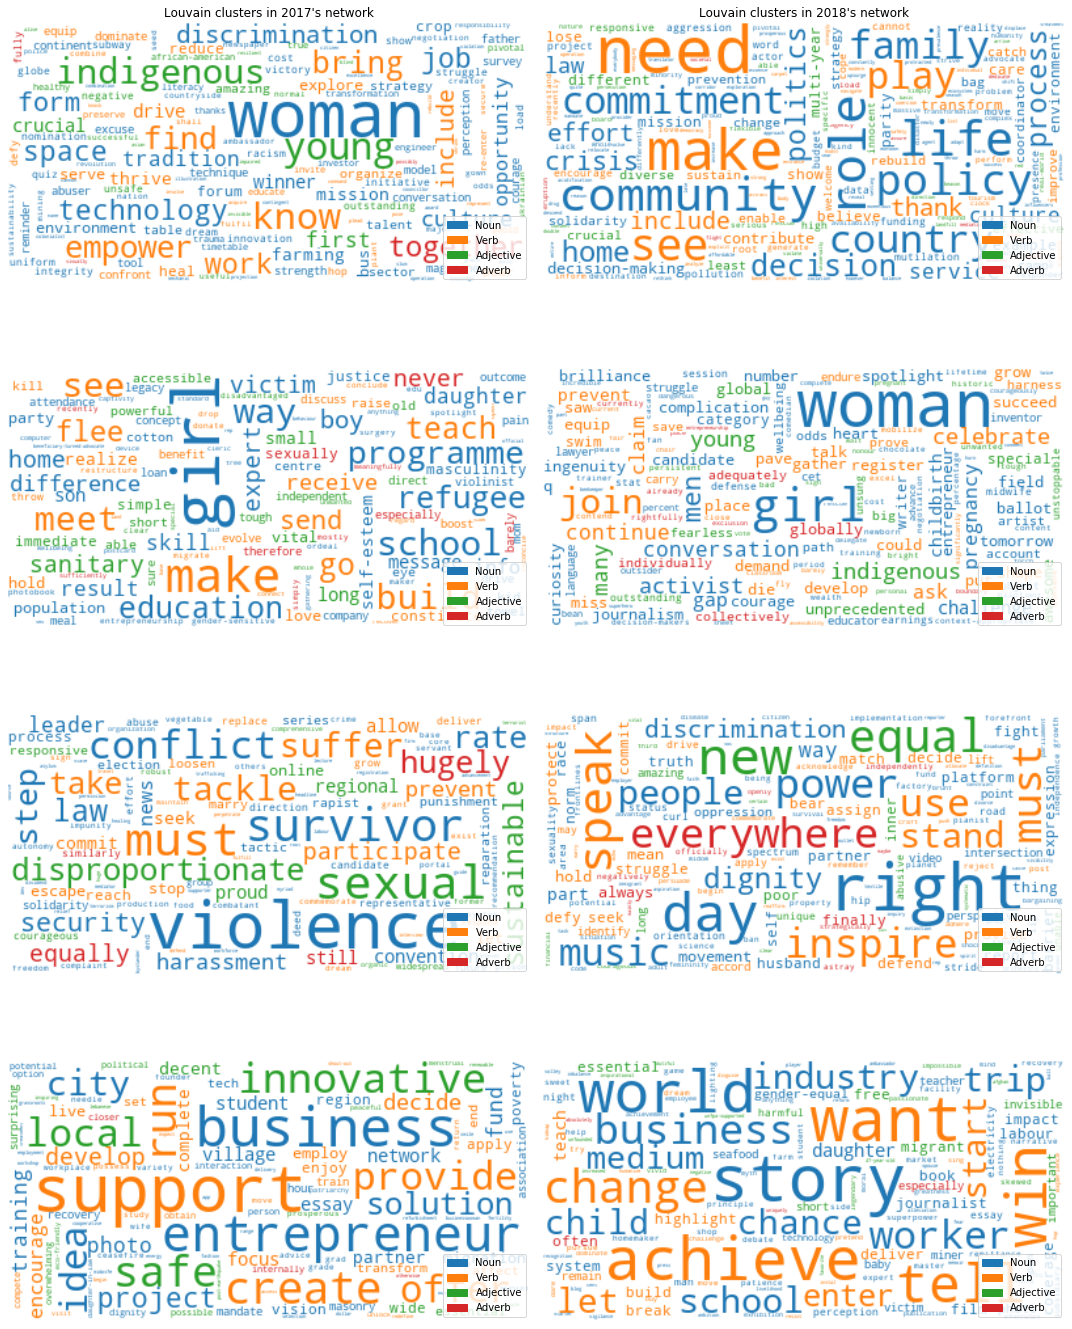

In [21]:
# Show wordclouds for Louvain clusters

# Initialize plot
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
_ = axs[0, 0].set_title('Louvain clusters in 2017\'s network')
_ = axs[0, 1].set_title('Louvain clusters in 2018\'s network')
# Fill plots
for i, y in enumerate(years):
    # Retrieve clusters for current year and sort them by numerosity
    clusters = sorted(lou_clusters[y], key=len, reverse=True)
    clusters = clusters[:num_clusters]
    # Plot every cluster
    for j, cluster in enumerate(clusters):
        # Compute degree score for each node in current cluster
        # Note: degree is a Pandas series mapping node to degree
        degree = get_degree(networks[y].subgraph(cluster)).sort_values(ascending=False)
        # degree = degree[:num_nodes]
        degree = degree / degree.sum()  # Scale degree
        degree.index = degree.index.map(lambda x: i2w[x])  # Map integer index to (word, pos) tuple
        # Create a WordCloud object using (word, POS tag) items
        word_cloud = make_word_cloud(WordCloud(max_font_size=50, background_color='white'), degree)
        # Plot wordclouds
        _ = axs[j, i].imshow(word_cloud, interpolation='bilinear')
        _ = axs[j, i].set_axis_off()
        _ = axs[j, i].legend(
            handles=[mpatches.Patch(color=pos_patches[k][0], label=pos_patches[k][1]) for k in pos_patches.keys()], 
            loc='lower right'
        )

# Show plot
_ = plt.tight_layout()
_ = plt.show()